In [1]:
%%capture
import __init__ as CFC

import math
import numpy as np
import matplotlib.pyplot as plt

import math
from scipy.optimize import root_scalar, root

# Problem Values

In [2]:
gamma = 1.4

press_one = 56e3
temp_one = 260
mach_one = 4.0

theta_one = math.radians(8)
theta_two = math.radians(13)

## First Oblique Shock (a)

In [3]:
one_to_two = CFC.ObliqueShock(gamma, mach=mach_one, theta=theta_one)
one_to_two.tbm

Theta: 0.139626
Beta:  0.357299
Mach:  4.000000

In [4]:
press_two = press_one * one_to_two.shock_ratio.pressure_ratio
temp_two = temp_one * one_to_two.shock_ratio.temp_ratio
mach_two = one_to_two.mach_two

press_two, temp_two, mach_two

(118533.73296473926, 326.0494342199998, 3.4272331299323535)

In [5]:
print(f"Shock angle (to Horizontal): {math.degrees(one_to_two.tbm.beta):.4f}\nPressure in region 2: {press_two/1e3:.2f} KPa\nTemperature in region 2: {temp_two:.2f} K\nMach number in region 2: {mach_two:.2f}")

Shock angle (to Horizontal): 20.4717
Pressure in region 2: 118.53 KPa
Temperature in region 2: 326.05 K
Mach number in region 2: 3.43


## Second Oblique Shock (b)

In [6]:
two_to_three = CFC.ObliqueShock(gamma, mach=mach_two, theta=theta_two - theta_one)
two_to_three.tbm

Theta: 0.087266
Beta:  0.358711
Mach:  3.427233

In [7]:
press_three = press_two * two_to_three.shock_ratio.pressure_ratio
temp_three = temp_two * two_to_three.shock_ratio.temp_ratio
mach_three = two_to_three.mach_two

press_three, temp_three, mach_three

(180441.39299916255, 368.4344244343824, 3.1336021012921016)

In [8]:
print(f"Shock angle (to Horizontal): {math.degrees(two_to_three.tbm.beta + theta_one):.4f}\nPressure in region 3: {press_three/1e3:.2f} KPa\nTemperature in region 3: {temp_three:.2f} K\nMach number in region 3: {mach_three:.2f}")

Shock angle (to Horizontal): 28.5526
Pressure in region 3: 180.44 KPa
Temperature in region 3: 368.43 K
Mach number in region 3: 3.13


## Wave Type Determination (c)

In [9]:
# Beta Values are in Radians in Reference frame of the flow

def potential_press_five(beta):
    one_to_five = CFC.ObliqueShock(gamma, mach=mach_one, beta=beta)
    return press_one * one_to_five.shock_ratio.pressure_ratio, one_to_five.theta

def potential_oblique_press_four(beta):
    # flow is at theta_two relative to horiz
    three_to_four = CFC.ObliqueShock(gamma, mach=mach_three, beta=beta)
    return press_three * three_to_four.shock_ratio.pressure_ratio, theta_two - three_to_four.theta 

def potential_prandtl_press_four(far_side_mach):
    pm = CFC.PrandtlMeyer(gamma, mach_one=mach_three, mach_two=far_side_mach)

    press_ratio = CFC.IsentropicRatio(gamma, mach_three).pressure_ratio / CFC.IsentropicRatio(gamma, far_side_mach).pressure_ratio
    return press_three * press_ratio, theta_two - pm.theta

In [10]:
betas = np.linspace(1e-6, np.pi/2, 100)

press_fives, theta_fives = zip(*[potential_press_five(beta) for beta in betas])
press_four_obliques, theta_four_obliques = zip(*[potential_oblique_press_four(beta) for beta in betas])


mach_fours = np.linspace(mach_three, 10.0, 100)
press_four_prandtls, theta_four_prandtls = zip(*[potential_prandtl_press_four(mach) for mach in mach_fours])


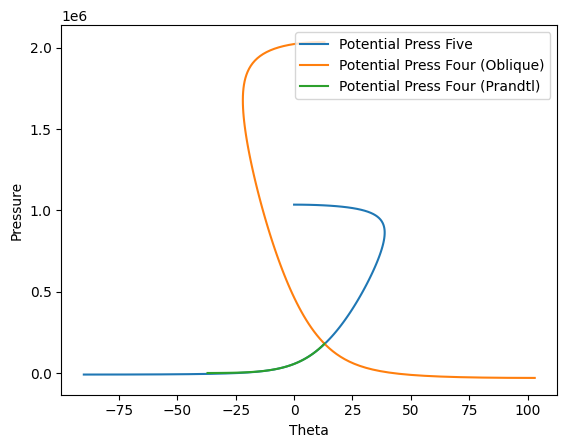

In [11]:

plt.plot([math.degrees(t) for t in theta_fives], press_fives, label='Potential Press Five')
plt.plot([math.degrees(t) for t in theta_four_obliques], press_four_obliques, label='Potential Press Four (Oblique)')
plt.plot([math.degrees(t) for t in theta_four_prandtls], press_four_prandtls, label='Potential Press Four (Prandtl)')

plt.xlabel('Theta')
plt.ylabel('Pressure')
plt.legend()
plt.show()

### Compute the dual oblique shock intersection point

In [12]:
def residuals(betas):
    beta_five, beta_four = betas
    press_five, theta_five = potential_press_five(beta_five)
    press_four, theta_four = potential_oblique_press_four(beta_four)

    return [press_five - press_four, theta_five - theta_four]

In [13]:
sol = root(residuals, [0.1, 0.1])
sol.x

array([0.43873901, 0.32388911])

In [14]:
press_five, theta_five = potential_press_five(sol.x[0])
press_four, theta_four = potential_oblique_press_four(sol.x[1])

print(f"Press 5: {press_five/1e3:.2f} KPa, Theta 5: {math.degrees(theta_five):.4f}")
print(f"Press 4: {press_four/1e3:.2f} KPa, Theta 4: {math.degrees(theta_four):.4f}")

Press 5: 179.30 KPa, Theta 5: 13.0784
Press 4: 179.30 KPa, Theta 4: 13.0784


## Solve for the conditions in region 4 & 5 (d)

In [15]:
one_to_five = CFC.ObliqueShock(gamma, mach=mach_one, beta=sol.x[0])
mach_five = one_to_five.mach_two

In [16]:
three_to_four = CFC.ObliqueShock(gamma, mach=mach_three, beta=sol.x[1])
mach_four = three_to_four.mach_two

In [17]:
print(f"Pressure @ 5: {press_five/1e3:.2f} KPa")
print(f"Mach 5: {mach_five:.4f}")
print(f"Mach 4: {mach_four:.4f}")
print(f"Theta 5: {math.degrees(theta_five):.4f}")

Pressure @ 5: 179.30 KPa
Mach 5: 3.0669
Mach 4: 3.1379
Theta 5: 13.0784


## What happens when the wave between 3 & 4 reaches the wedge (e)

I believe there are an infinite cascade of oblique shocks as the flow from region 4 onwards becomes compressed into less and less space between the slipline of 4 & 5 and the wedge.

Probably something like the path of a ball bouncing between the slipline and the wedge